In [1]:
import anndata as ad
from anndata import read_h5ad
import dask.distributed as dd
import h5py
import scanpy as sc

In [2]:
tissue = 'heart'

In [3]:
path = f'data/{tissue}.h5ad'

In [4]:
cluster = dd.LocalCluster(n_workers=3, dashboard_address=":8786")
client = dd.Client(cluster)
client

<Client: 'tcp://127.0.0.1:40495' processes=3 threads=66, memory=246.55 GiB>

In [5]:
dask_chunk_size = 100_000

In [6]:
f = h5py.File(path, "r")
f

<HDF5 file "heart.h5ad" (mode r)>

In [7]:
%%time
a = ad.AnnData(
    obs=ad.io.read_elem(f["obs"]),
    var=ad.io.read_elem(f["var"]),
)
a.X = ad.experimental.read_elem_as_dask(
    f["X"], chunks=(dask_chunk_size, a.shape[1])
)
a

CPU times: user 2.56 s, sys: 458 ms, total: 3.02 s
Wall time: 2.91 s


AnnData object with n_obs × n_vars = 1559974 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [8]:
a.X

dask.array<make_dask_chunk, shape=(1559974, 60530), dtype=float32, chunksize=(100000, 60530), chunktype=scipy.csr_matrix>

In [9]:
%%time
a.layers["counts"] = a.X.copy()  # Making sure we keep access to the raw counts
sc.pp.normalize_total(a, target_sum=1e4)

CPU times: user 10.8 ms, sys: 2 ms, total: 12.8 ms
Wall time: 12.3 ms


In [10]:
a.layers["counts"].dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7e28557e6780>
 0. original-block-info-make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 1. block-info-make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 2. make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3

In [11]:
a.X.dask

HighLevelGraph with 8 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7e285a7b0fe0>
 0. original-block-info-make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 1. block-info-make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 2. make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 3. sum_drop_keepdims-a4be0ccef67951f62c3dd794e718738d
 4. aggregate_sum-aggregate-35fb6165244d415c3eb60df3112bcdc0
 5. truediv-eccf8d4f3b5d11e3d97ae0ad5c75ab76
 6. getitem-0172841d02bf673eb24a19b522e33536
 7. axis_mul_or_truediv-769a9892b10648e54f18a080b2150065

In [12]:
%%time
sc.pp.log1p(a)

CPU times: user 2.51 ms, sys: 0 ns, total: 2.51 ms
Wall time: 2.51 ms


In [13]:
a.X.dask

HighLevelGraph with 9 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7e285a7b2d80>
 0. original-block-info-make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 1. block-info-make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 2. make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 3. sum_drop_keepdims-a4be0ccef67951f62c3dd794e718738d
 4. aggregate_sum-aggregate-35fb6165244d415c3eb60df3112bcdc0
 5. truediv-eccf8d4f3b5d11e3d97ae0ad5c75ab76
 6. getitem-0172841d02bf673eb24a19b522e33536
 7. axis_mul_or_truediv-769a9892b10648e54f18a080b2150065
 8. log1p-ea664ce5a512bb53a1b30eac594f9644

In [14]:
%%time
sc.pp.highly_variable_genes(a)

CPU times: user 6.65 s, sys: 797 ms, total: 7.45 s
Wall time: 1min 39s


In [15]:
%%time
sc.pp.pca(a)

CPU times: user 1min 11s, sys: 1.43 s, total: 1min 12s
Wall time: 1min 53s


In [18]:
a.obsm

AxisArrays with keys: X_pca

In [17]:
a.obsm["X_pca"].dask

HighLevelGraph with 11 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7e2851b4b110>
 0. original-block-info-make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 1. block-info-make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 2. make_dask_chunk-4f44da4ab2cc3baae038b4e9bdc70fe3
 3. sum_drop_keepdims-a4be0ccef67951f62c3dd794e718738d
 4. aggregate_sum-aggregate-35fb6165244d415c3eb60df3112bcdc0
 5. truediv-eccf8d4f3b5d11e3d97ae0ad5c75ab76
 6. getitem-0172841d02bf673eb24a19b522e33536
 7. axis_mul_or_truediv-769a9892b10648e54f18a080b2150065
 8. log1p-ea664ce5a512bb53a1b30eac594f9644
 9. getitem-3d8af5a8b94831657437293ac49091a0
 10. transform_block-af46da3df3373e17c78e260061a3bd61

In [19]:
%%time
a.obsm["X_pca"] = a.obsm["X_pca"].compute()

CPU times: user 6.24 s, sys: 1.23 s, total: 7.47 s
Wall time: 1min 35s


In [20]:
a

AnnData object with n_obs × n_vars = 1559974 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [23]:
a.obs.columns

Index(['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id',
       'cell_type', 'cell_type_ontology_term_id', 'development_stage',
       'development_stage_ontology_term_id', 'disease',
       'disease_ontology_term_id', 'donor_id', 'is_primary_data',
       'observation_joinid', 'self_reported_ethnicity',
       'self_reported_ethnicity_ontology_term_id', 'sex',
       'sex_ontology_term_id', 'suspension_type', 'tissue',
       'tissue_ontology_term_id', 'tissue_type', 'tissue_general',
       'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz',
       'raw_variance_nnz', 'n_measured_vars'],
      dtype='object')

In [32]:
t10 = a.obs.cell_type.value_counts().iloc[:10]
t10

cell_type
cardiac muscle cell                    284321
fibroblast of cardiac tissue           170070
mural cell                             128390
regular ventricular cardiac myocyte    125289
endothelial cell                       118837
pericyte                                92277
unknown                                 84552
fibroblast                              74476
cardiac muscle myoblast                 66335
capillary endothelial cell              59326
Name: count, dtype: int64

In [34]:
a10 = a[a.obs.cell_type.isin(t10.index)]
a10

View of AnnData object with n_obs × n_vars = 1203873 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'cell_type_colors', 'tissue_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [35]:
a10.obs.cell_type.dtype

CategoricalDtype(categories=['capillary endothelial cell', 'cardiac muscle cell',
                  'cardiac muscle myoblast', 'endothelial cell', 'fibroblast',
                  'fibroblast of cardiac tissue', 'mural cell', 'pericyte',
                  'regular ventricular cardiac myocyte', 'unknown'],
, ordered=False, categories_dtype=object)

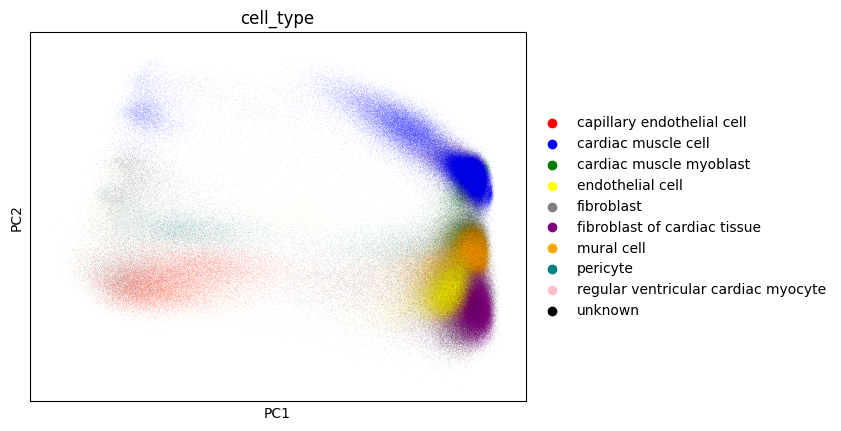

In [45]:
sc.pl.pca(a10, color="cell_type", palette=["red", "blue", "green", "yellow", "grey", "purple", "orange", "teal", "pink", "black"])